# Heat equation - Retrieving operator through ODE solving

In [131]:
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using DifferentialEquations
using Plots
using GalacticOptim
using MLUtils
using IterTools: ncycle
using LinearAlgebra
using DiffEqSensitivity
using Zygote
using BSON: @save

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")

include("src/examples/heat/heat_training.jl")

Main.HeatTraining

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [3]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

typ = 3;
d = 1.;
k = 1.;
kappa = 0.005;
L = x_max - x_min
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

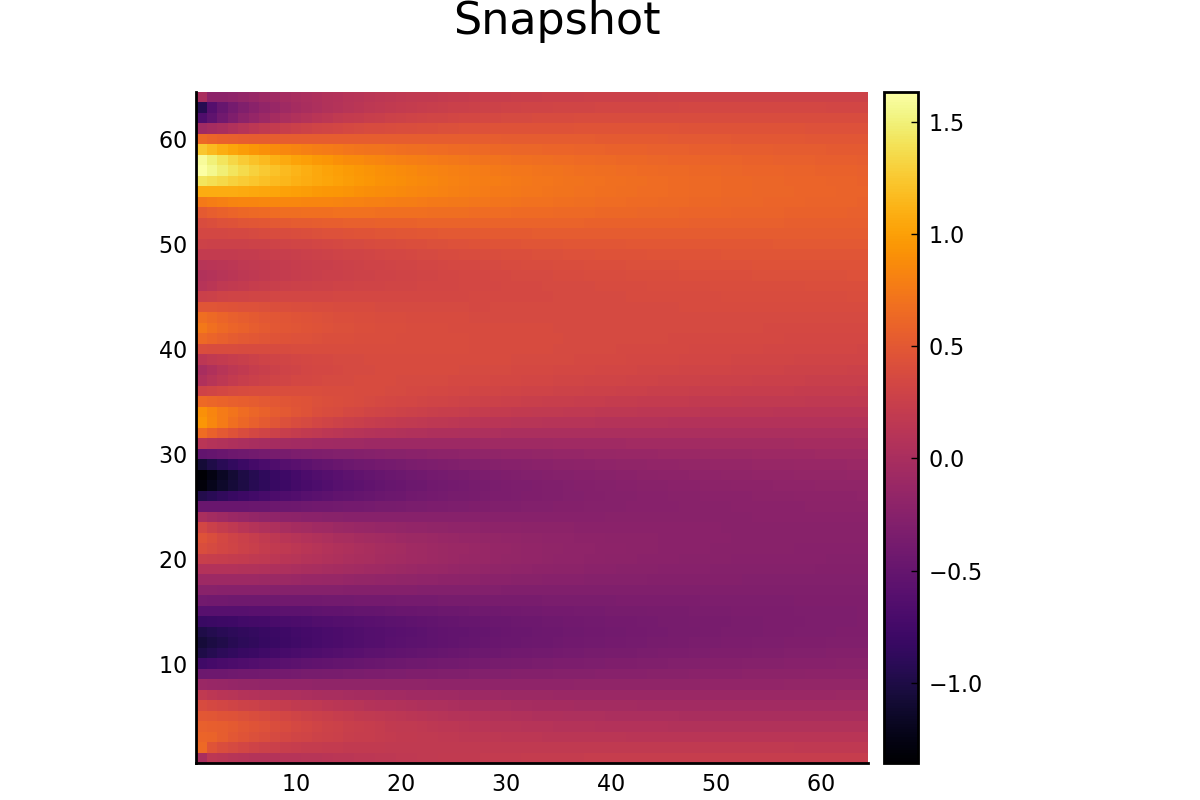

In [4]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

# u0 = InitialFunctions.heat_analytical_init(t, x, n, c, kappa);
u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

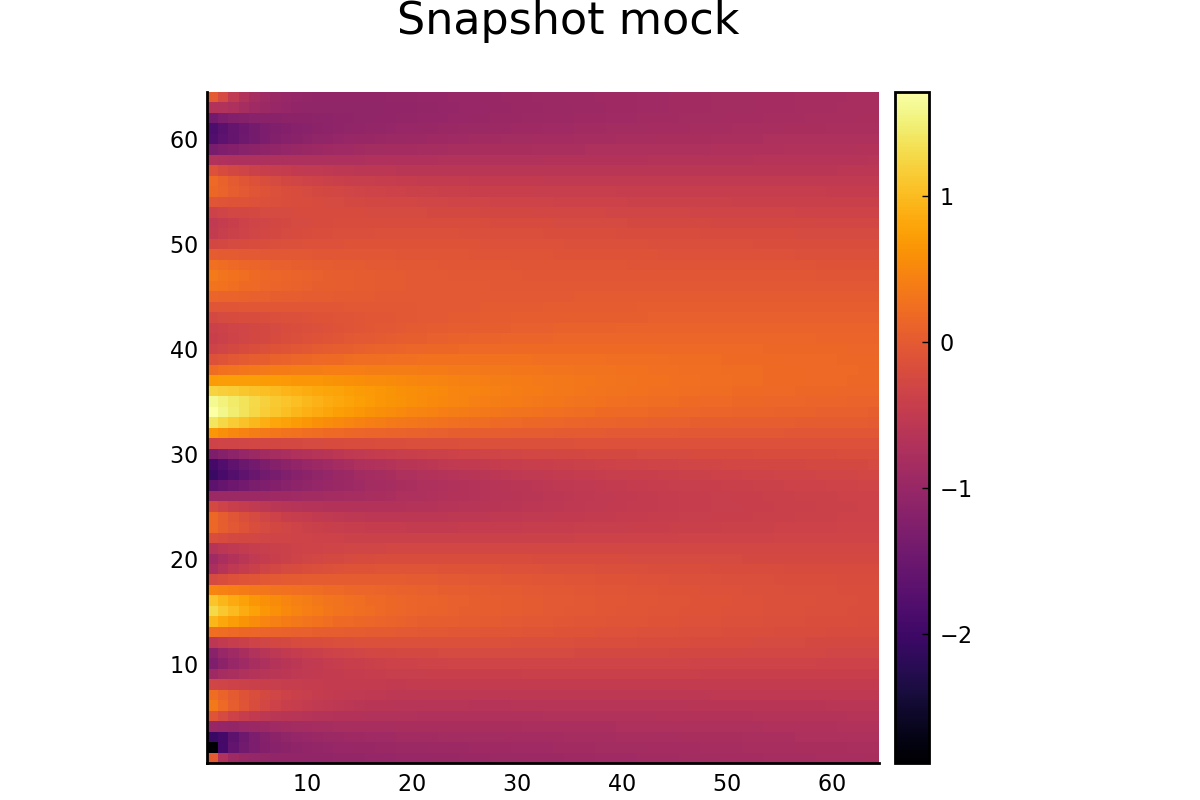

In [5]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k)
GraphicTools.show_state(u_a, "Snapshot mock")

## Generate dataset

In [13]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 128, 2, kappa, k, "./src/dataset/heat_high_dim_training_set.jld2", "training_set");
# hand_dataset = Generator.read_dataset("./src/dataset/hand_analytical_heat_training_set.jld2")["training_set"];
# analytic_dataset = Generator.read_dataset("./src/dataset/odesolver_analytical_heat_training_set.jld2")["training_set"];
high_dataset = Generator.read_dataset("./src/examples/heat/heat_high_dim_training_set.jld2")["training_set"];

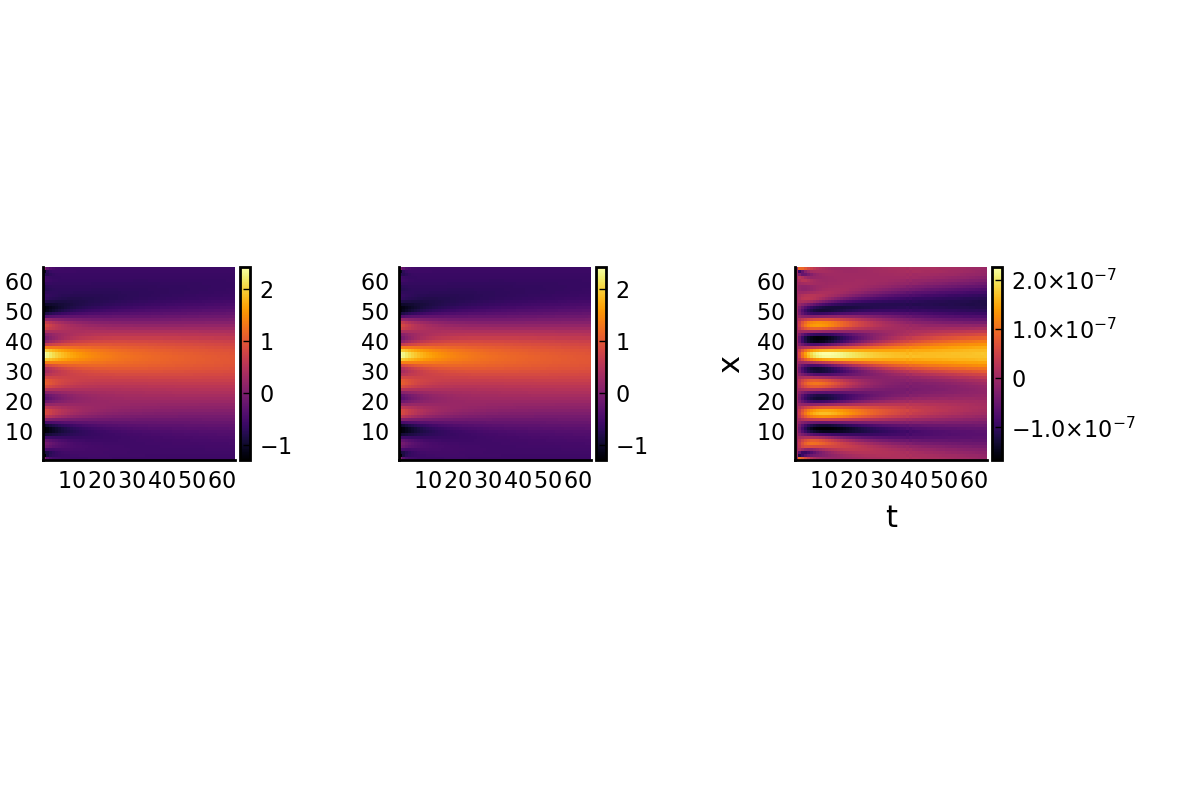

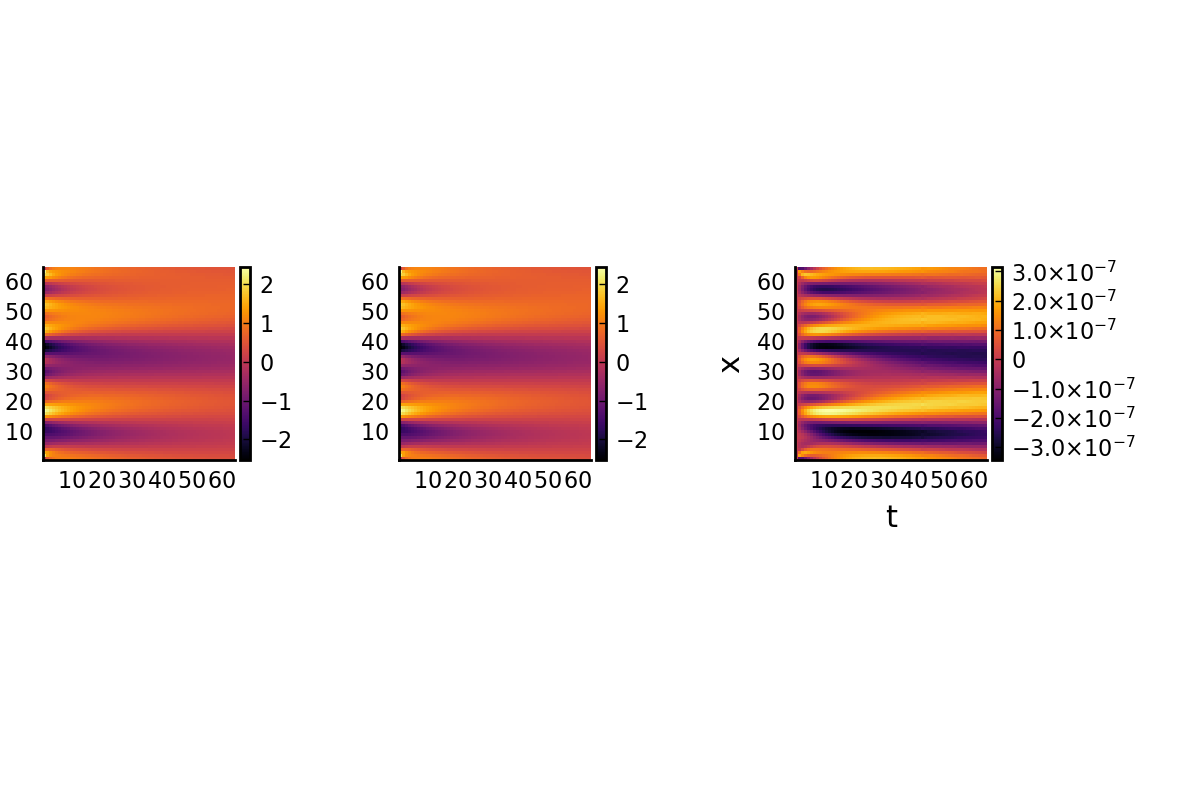

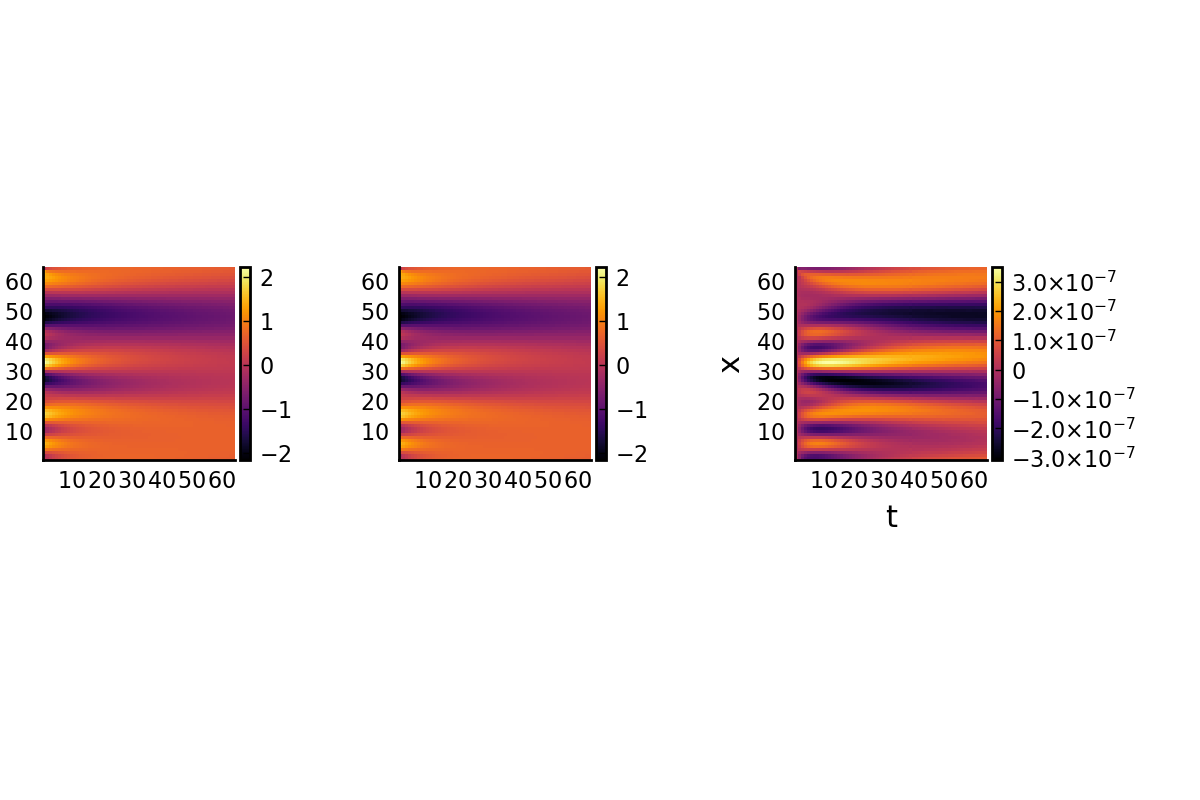

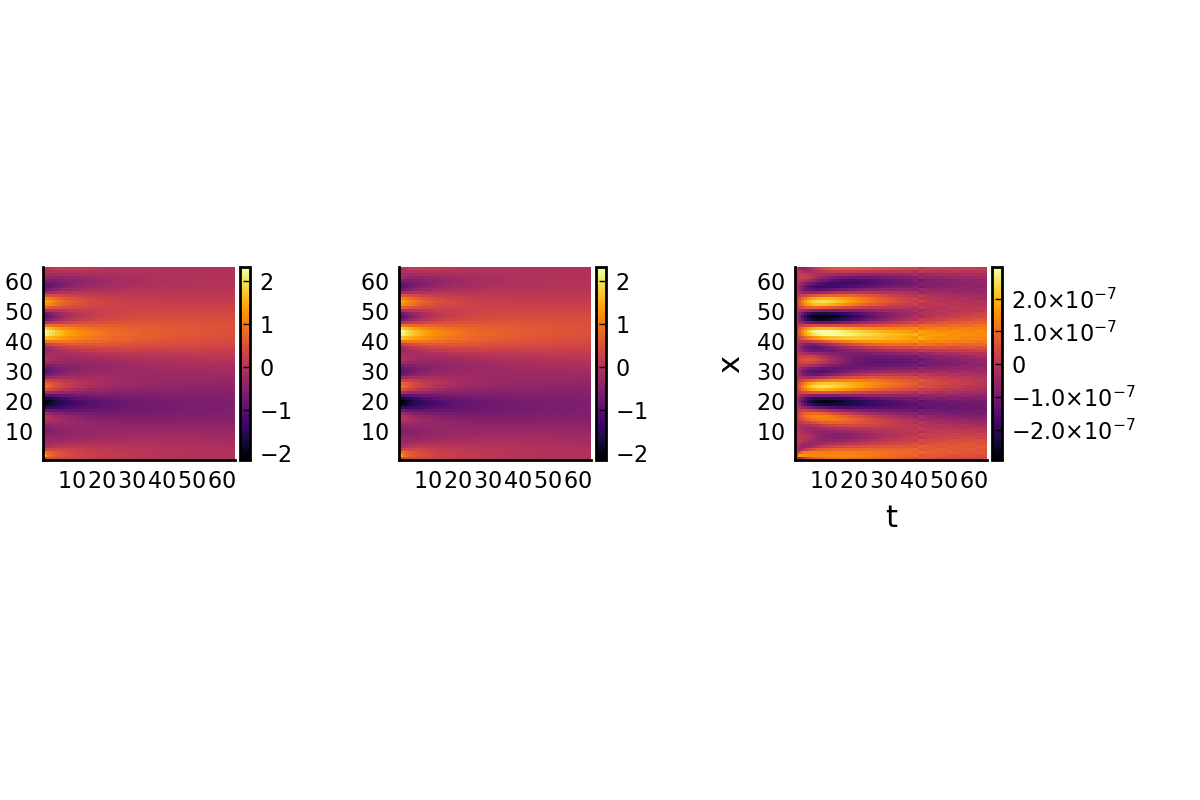

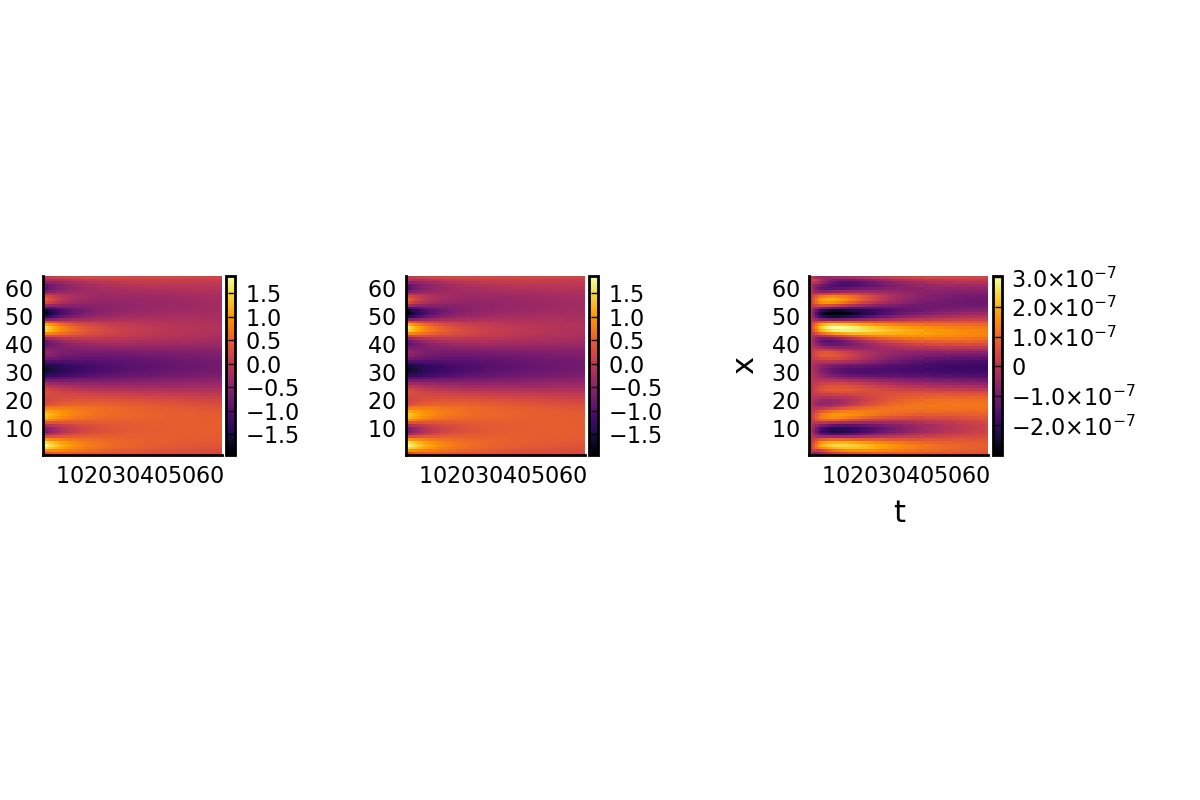

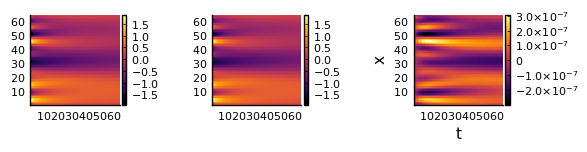

In [14]:
function check_training_dataset(dataset)
    for i in range(1, 5, step=1)
        a, b, _, d = dataset[i];
        _, c = Equations.get_heat_fft(a, dx, x_n, kappa, b[:, 1]);    
        display(
            plot(
            # GraphicTools.show_err(b, d, ""),
            GraphicTools.show_state(b, ""),
            GraphicTools.show_state(c, ""),
            GraphicTools.show_err(c, b, "", "t", "x");
            layout = (1, 3),
            );
        );
    end
end

check_training_dataset(high_dataset)

---
# Operator reconstruction 

In [11]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, x_n, t_n, typ, kappa, k);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t);
    u_pred = prob_neuralode(u0, res);

    display(
        plot(
            GraphicTools.show_state(u, ""),
            GraphicTools.show_state(hcat(u_pred.u...), ""),
            GraphicTools.show_err(hcat(u_pred.u...), u, "");
            layout = (1, 3),
        )
    )
end

check_result (generic function with 1 method)

In [12]:
function get_data_loader(dataset, batch_size, ratio)
  t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);

  t_train, t_val = splitobs(t, at = ratio);
  train_set, val_set = splitobs(true_set, at = ratio);
  init_train = copy(init_set);
  init_val = copy(val_set[:, :, 1]);

  switch_train_set = permutedims(train_set, (1, 3, 2));
  switch_val_set = permutedims(val_set, (1, 3, 2));

  train_loader = DataLoader((init_train, switch_train_set, collect(ncycle([collect(t_train)], batch_size))), batchsize=batch_size, shuffle=false);
  val_loader = DataLoader((init_val, switch_val_set, collect(ncycle([collect(t_val)], batch_size))), batchsize=batch_size, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader (generic function with 1 method)

In [170]:
function training(model, epochs, dataset, batch_size, ratio)
  opt = Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8);
  ltrain = 0;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = get_data_loader(dataset, batch_size, ratio);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
      tspan = (t[1], t[end]);
      _prob = remake(prob; u0=x, p=p, tspan=tspan);
      Array(solve(_prob, Tsit5(), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
      u_pred = predict_neural_ode(x, t[1]);
      ŷ = Reg.augment(u_pred, 1.e-6);
      l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) + Reg.l2(p, 1e-3);
      return l;
  end

  function traincb()
      ltrain = 0;
      for (x, y, t) in train_loader
           ltrain += loss(x, y, t);
      end
      ltrain /= (train_loader.nobs / train_loader.batchsize);
      @show(ltrain);
  end

  function evalcb()
      lval = 0;
      for (x, y, t) in val_loader
           lval += loss(x, y, t);
      end
      lval /= (val_loader.nobs / val_loader.batchsize);
      @show(lval);
  end

  @info("Train")
  Flux.@epochs epochs begin
        Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
        trigger = Flux.plateau(() -> ltrain, 10);
        trigger() && break;
  end

  return re(p), p
end

training (generic function with 1 method)

In [171]:
function main()
  batch_size = 128;
  epochs = 100;

  high_dataset = Generator.read_dataset("./src/examples/heat/heat_high_dim_training_set.jld2")["training_set"];
  model = Models.LinearModel(x_n);
  K, p = training(model, epochs, high_dataset, batch_size, 0.7);
  # @save "HeatLinearModel.bson" cpu(neural_operator)
  return K, p
end

K, p = main()

┌ Info: Loading dataset
└ @ Main In[170]:5
┌ Info: Building model
└ @ Main In[170]:8
┌ Info: Train
└ @ Main In[170]:45
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.35796051852067085
lval = 0.0019517587855632683


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3207447552218761
lval = 0.003029533747552314


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2908896576113104
lval = 0.004675530985059688


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.26628764431177204
lval = 0.006698243948996652


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24560409914642914
lval = 0.008942582950974437


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22798259975465665
lval = 0.011293599584214647


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21286169273960792
lval = 0.01367669615696696


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1998383449098523
lval = 0.016045011003263564


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18858370105580322
lval = 0.0183668334967181


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1788136139450525
lval = 0.02061841934511862


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17028928655071043
lval = 0.022781354808573444


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16281885963707388
lval = 0.02484281501694168


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15625048399705876
lval = 0.02679535437611441


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15046239331089586
lval = 0.028635817877552455


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14535526737363802
lval = 0.030364174552378775


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14084671302276358
lval = 0.03198254242031643


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13686680040006244
lval = 0.03349406533480006


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1333543531035693
lval = 0.034902018432061845


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.130253682994679
lval = 0.03620931968257944


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12751270415322444
lval = 0.03741855703487172


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12508319943107082
lval = 0.038532367640478335


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12292281438249195
lval = 0.03955405165577234


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12099612524528572
lval = 0.04048786792415263


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11927335129646396
lval = 0.04133869587782381


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1177280676364674
lval = 0.04211170365837878


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11633573786765769
lval = 0.04281220248368415


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1150738016232435
lval = 0.04344552606205958


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11392248284950755
lval = 0.04401681199262645


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11286562517252408
lval = 0.04453100887754261


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11189086097098265
lval = 0.04499292061639848


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1109890833693318
lval = 0.04540722307956983


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11015369595477927
lval = 0.04577850339053379


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10937970623663607
lval = 0.04611109952210017


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10866307354064336
lval = 0.04640901739562615


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10800018171713349
lval = 0.046675811403963346


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10738749260156907
lval = 0.04691457140994447


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10682134874294776
lval = 0.04712789583239509


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10629798572281679
lval = 0.04731791508875712


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10581371757312233
lval = 0.04748633768964172


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10536511196692389
lval = 0.0476345133752911


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10494913240558623
lval = 0.04776358268975075


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1045631113838521
lval = 0.047874537872550325


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10420465728188508
lval = 0.04796829931625934


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10387161642249079
lval = 0.04804583496183623


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10356195960391724
lval = 0.048108176178148235


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10327383656426516
lval = 0.04815647127021805


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10300564020610768
lval = 0.04819203597156489


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1027560176725873
lval = 0.04821635424027047


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10252367742866293
lval = 0.048230944220512


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10230731211224545
lval = 0.04823730652985301


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10210562855234402
lval = 0.04823683609622826


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1019174952932393
lval = 0.04823085656147825


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10174194584965238
lval = 0.04822054956931519


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10157816703679282
lval = 0.04820700786593201


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10142538393439349
lval = 0.04819120757181399


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10128277464741332
lval = 0.04817397962577328


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10114960331560668
lval = 0.048156127169415745


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10102511134436294
lval = 0.04813831530006881


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10090861030494525
lval = 0.04812116968593096


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1007994262216434
lval = 0.04810521306292656


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10069692091713534
lval = 0.04809088508376954


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10060047809910602
lval = 0.04807850150486256


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10050948079729086
lval = 0.048068241315188415


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10042336159573137
lval = 0.048060167251309814


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10034160106901985
lval = 0.048054222216219945


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10026376261023051
lval = 0.0480502754014142


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10018946583394589
lval = 0.048048137642582256


┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10011845098964967
lval = 0.04804767572088001


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10005046989382828
lval = 0.04804874374003106


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09998532764673328
lval = 0.04805124563352555


┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09992287146228909
lval = 0.04805513058158491


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09986296256846798
lval = 0.04806035075426407


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09980549967634031
lval = 0.04806688143302989


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09975037303683712
lval = 0.04807465882586449


┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09969748652927013
lval = 0.04808359691419279


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09964673197332162
lval = 0.048093587171951


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09959800423177351
lval = 0.0481045150895314


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09955117686715731
lval = 0.048116251830224804


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09950618407783848
lval = 0.04812873744117302


┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09946291196260057
lval = 0.04814186497961801


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09942130077611414
lval = 0.04815558058718751


┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09938126154830355
lval = 0.04816978697803149


┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09934273894864169
lval = 0.04818440561303187


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09930566854099088
lval = 0.048199325435090465


┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09927000231040635
lval = 0.048214448078350534


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09923567665669619
lval = 0.048229663750616235


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09920265134589774
lval = 0.04824489816204513


┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09917089228372754
lval = 0.04826010344224892


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09914035701046103
lval = 0.04827524462590807


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09911100625514033
lval = 0.04829030544253523


┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09908280684029191
lval = 0.048305287266632004


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09905571402915038
lval = 0.04832018292890947


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09902968327343009
lval = 0.04833498084927169


┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09900468327710593
lval = 0.04834968812068678


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09898065176665084
lval = 0.04836428262197818


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09895757681140593
lval = 0.04837879860008091


┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09893540660922331
lval = 0.048393233559373874


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0989141122849218
lval = 0.04840760445332191


┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09889364985921073
lval = 0.048421918551926575


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09887400112296758
lval = 0.048436196835405294


(Chain(Dense(64 => 64; bias=false)), Float32[-0.0044998475, -0.05965098, -0.059942998, -0.054768216, -0.036336184, -0.013027453, 0.011525116, 0.0297453, 0.037121277, 0.034955155  …  0.022333162, 0.026874222, 0.023813972, 0.0127070965, -0.004953021, -0.029310534, -0.048001762, -0.059621103, -0.066952236, -0.002733289])

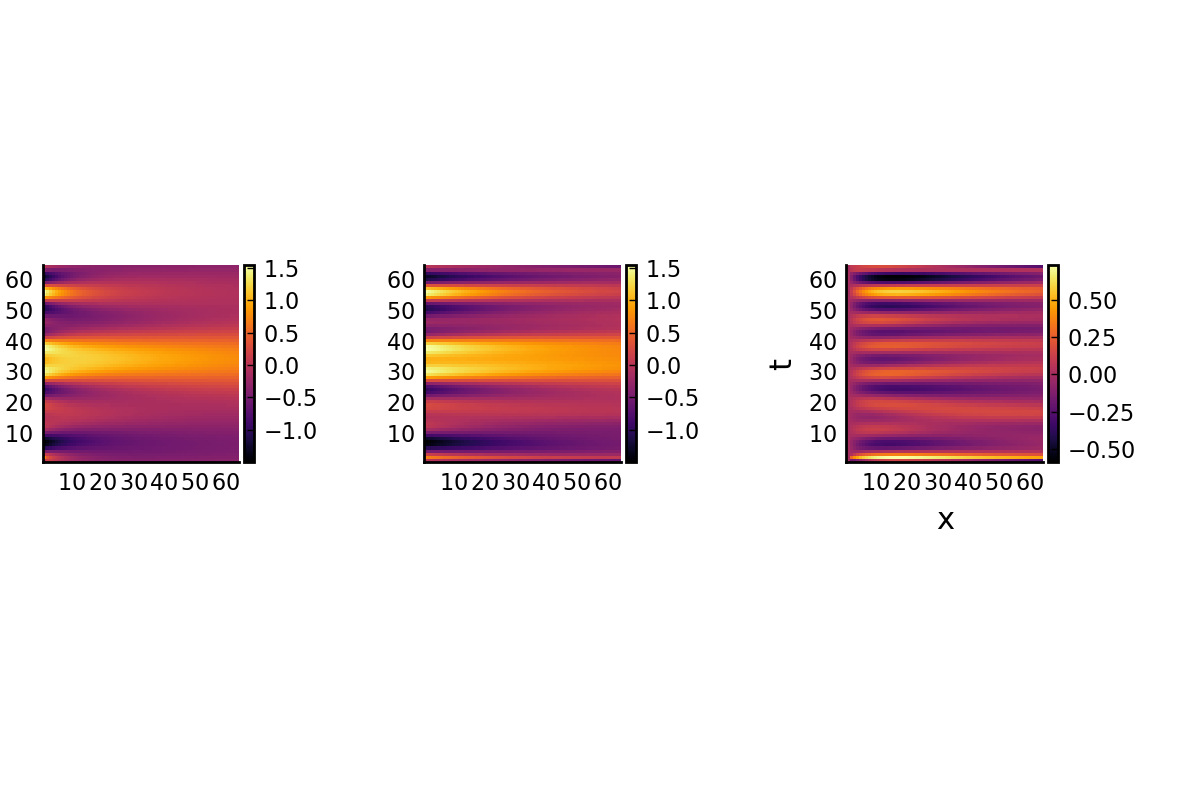

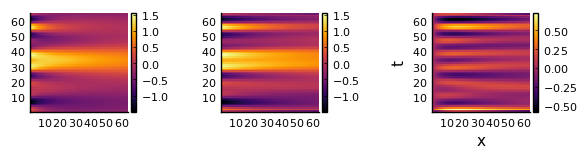

In [174]:
check_result(K, p, 2)

In [154]:
@save "HeatLinearModel.bson" K

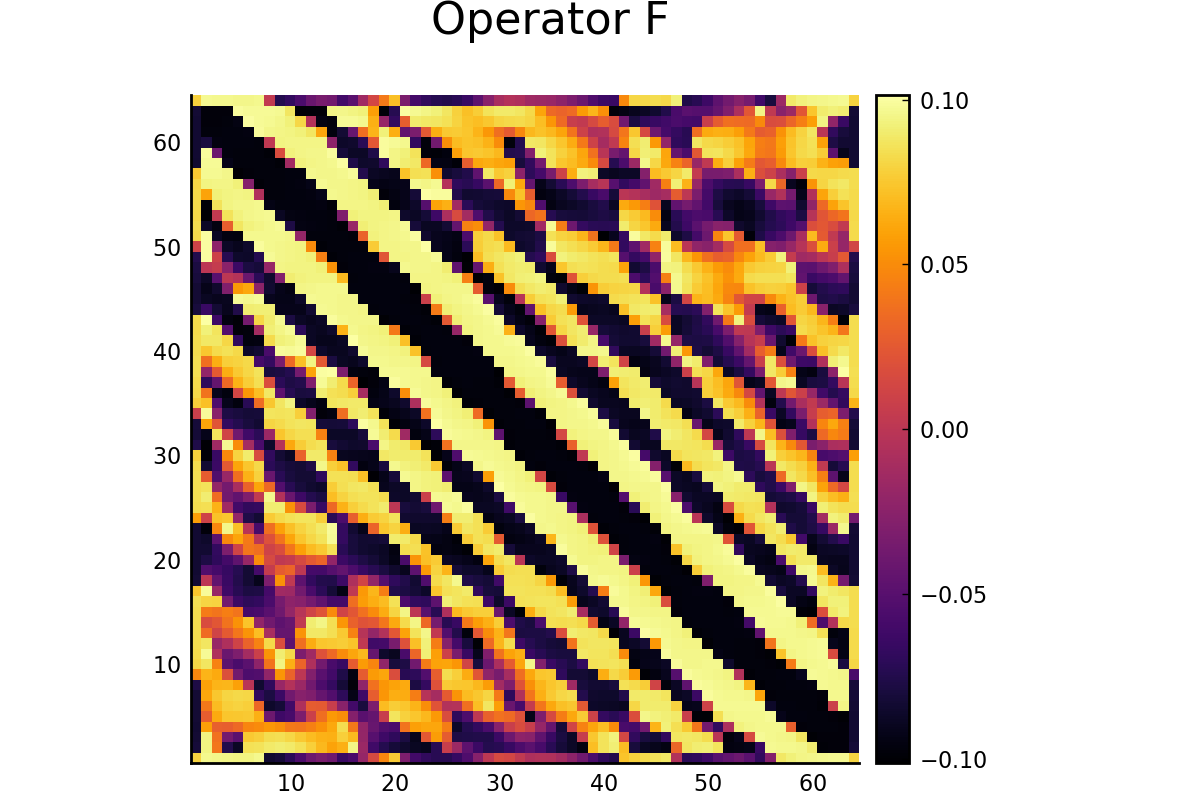

In [156]:
GraphicTools.show_state(reverse(Flux.params(K)[1]; dims = 1), "Operator F")

# gs = first(Flux.gradient(() -> loss(x, y, t), Flux.params(p)))
# GraphicTools.show_state(reshape(gs, (x_n, x_n)), "")

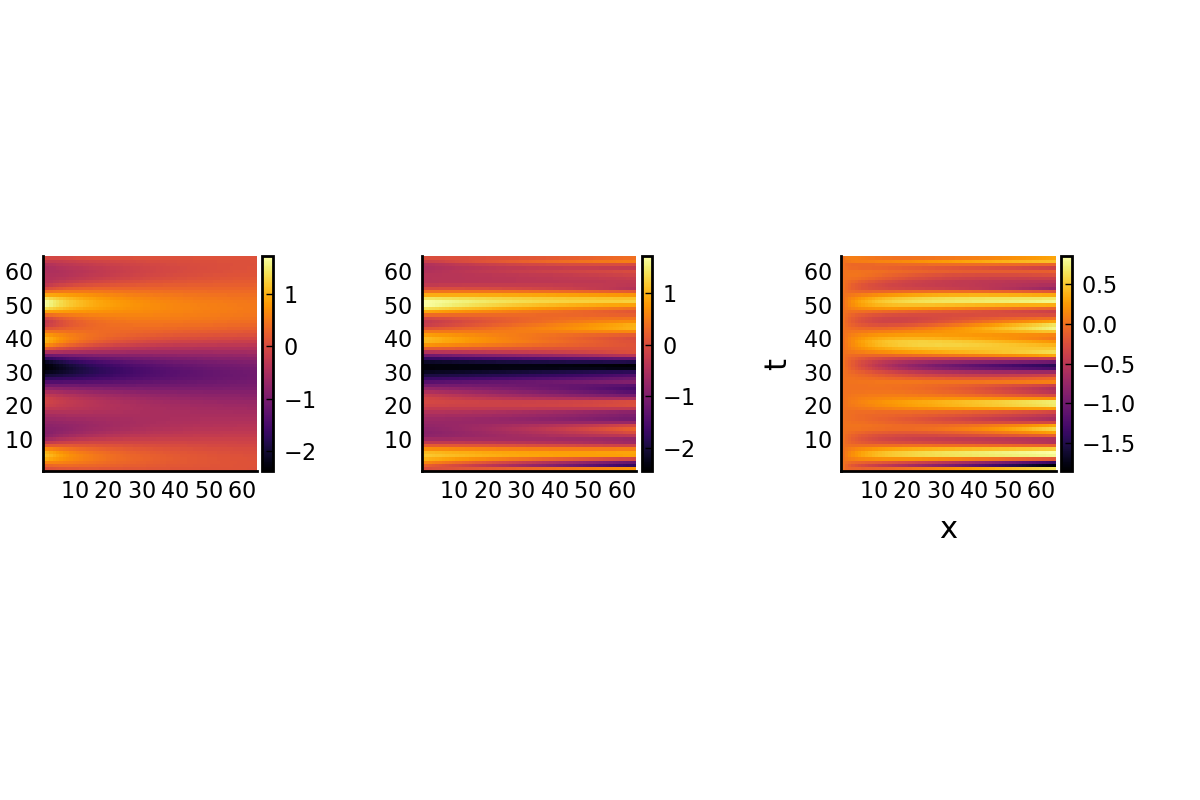

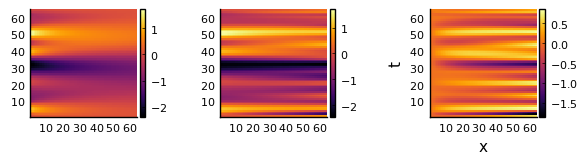

In [115]:
check_result(K, p, 2)

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k);
u_pred = Array(S(K, u0, t));

display(
    plot(
        GraphicTools.show_state(u_pred, ""),
        GraphicTools.show_state(u, "");
        layout = (1, 2),
    );
);

## Training with NeuralODE object

In [80]:
callback(theta, loss, u) = (IJulia.clear_output(true); display(loss); false)

callback (generic function with 1 method)

In [81]:
function heat_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-8 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

heat_training (generic function with 1 method)

In [82]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset);
net = Models.HeatModel(x_n);
result = heat_training(net, 2, init_set, true_set, t);

LoadError: MethodError: no method matching (OptimizationFunction{false, GalacticOptim.AutoZygote, OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, GalacticOptim.var"#128#138"{GalacticOptim.var"#127#137"{OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Nothing}}, GalacticOptim.var"#131#141"{GalacticOptim.var"#127#137"{OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Nothing}}, GalacticOptim.var"#136#146", Nothing, Nothing, Nothing, HP, CJP, CHP, S, HCV, CJCV, CHCV, EX, CEX} where {HP, CJP, CHP, S, HCV, CJCV, CHCV, EX, CEX})(::OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, ::GalacticOptim.AutoZygote, ::GalacticOptim.var"#128#138"{GalacticOptim.var"#127#137"{OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Nothing}}, ::GalacticOptim.var"#131#141"{GalacticOptim.var"#127#137"{OptimizationFunction{true, GalacticOptim.AutoZygote, DiffEqFlux.var"#84#91"{var"#loss#53"{Array{Float64, 3}, var"#predict_neural_ode#52"{Matrix{Float64}, NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}}}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Nothing}}, ::GalacticOptim.var"#136#146", ::Nothing, ::Nothing, ::Nothing)

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
dLdK = first(Zygote.gradient(loss, K))
GraphicTools.show_state(reverse(dLdK; dims=1), "dLdK")

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k);
u_pred = Array(S(K, u0, t));

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

---

## Training with solver

In [ ]:
function f(u, K, t)
  return K * u
end

In [ ]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
callback(A, loss) = (println(loss); flush(stdout); false)

In [ ]:
function heat_training_solver(A, epochs, u0, u_true, tsnap)
    
  function loss(A)
    u_pred = Array(S(A, u0, tsnap))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

In [ ]:
net = zeros(x_n, x_n);

### Train with different data sets

Hand (data obtained from analytical solution), analytical (analytical solution at t=0 + ode solver), high dimension data set (from burgers to generate shock).

In [ ]:
t4, u04, u_true4 = ProcessingTools.process_dataset(hand_dataset);
result_5 = heat_training_solver(copy(net), 100, u04, u_true4, t4);


In [ ]:
t, u0, u_true = ProcessingTools.process_dataset(analytic_dataset);
result_2 = heat_training_solver(copy(net), 100, u0, u_true, t);


In [ ]:
t2, init, train = syver_dataset;
result_3 = heat_training_solver(copy(net), 1000, init, train, t2);


In [ ]:
t3, u03, u_true3 = ProcessingTools.process_dataset(high_dataset);
result_4 = heat_training_solver(copy(net), 100, u03, u_true3, t3);


In [ ]:
K2 = result_2.u
K3 = result_3.u;
K4 = result_4.u;
K5 = result_5.u;

display(
    plot(
        GraphicTools.show_state(reverse(K2; dims = 1), ""),
        GraphicTools.show_state(reverse(K3; dims = 1), ""),
        GraphicTools.show_state(reverse(K4; dims = 1), ""),
        GraphicTools.show_state(reverse(K5; dims = 1), "");
        layout = (2, 2),
    ),
);  

In [ ]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 4, kappa, k);
u_pred_2 = Array(S(K2, u0, t));
u_pred_3 = Array(S(K3, u0, t));
u_pred_4 = Array(S(K4, u0, t));

display(
    plot(
        GraphicTools.show_state(u, "data"),
        GraphicTools.show_state(u_pred_2, "prediction 2"),
        GraphicTools.show_state(u_pred_3, "prediction 3"),
        GraphicTools.show_state(u_pred_4, "prediction 4");
        layout = (2, 2),
        reuse = false
    ),
);

In [ ]:
function test_simulation(net, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
        u_pred = Array(S(net, u0, t));
        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

In [ ]:
println(test_simulation(K2, 100, 1))
println(test_simulation(K2, 100, 2))
println(test_simulation(K2, 100, 3))
println(test_simulation(K2, 100, 4))

In [ ]:
println(test_simulation(K3, 100, 1))
println(test_simulation(K3, 100, 2))
println(test_simulation(K3, 100, 3))
println(test_simulation(K3, 100, 4))

In [ ]:
println(test_simulation(K4, 100, 1))
println(test_simulation(K4, 100, 2))
println(test_simulation(K4, 100, 3))
println(test_simulation(K4, 100, 4))